In [1]:
import numpy as np
import torch

import matplotlib.pyplot as plt

from utils.helper_functions import load_dm
from utils.arguments import get_parser

from nets.wrapper import ContrastiveWrapper

from pytorch_lightning import Trainer

In [2]:
parser = get_parser()
args = parser.parse_args('''
--dataset UCI-HAR --batch_size 128 --window_size 40 --normalize --subjects_for_test 21 20 19 18 17 
--max_epochs 10 --lr 0.01 --training_dir training_clr --n_val_subjects 4 --reduce_imbalance
--encoder_architecture cnn_gap_ts --encoder_features 20 --cf 0.001 --mode clr3'''.split())

dm = load_dm(args)

Loaded dataset UCI-HAR with a total of 815614 observations for window size 40
Sampling 51607 (balanced) observations per epoch.
Using 631395 observations for training, 106617 for validation and 143333 for test


In [3]:
model = ContrastiveWrapper.load_from_checkpoint(checkpoint_path="_tests/clr3_UCI-HAR_21-20-19-18-17_4_40_1_bs128_lr0.001_l10_l20_cnn_gap_ts20_cnn_ts_decNone_1_v10_0.1_decay0.001/version_0/checkpoints/epoch=26-step=10233-val_re=0.0000.ckpt")
model.eval()
print()

Input shape:  torch.Size([1, 6, 40])
Latent shape:  torch.Size([1, 80])



/home/mbikandi/miniconda3/envs/dev2/lib/python3.10/site-packages/torch/nn/modules/conv.py:306: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1040.)
  return F.conv1d(input, weight, bias, self.stride,


In [4]:
labels = []
d = 3300
for i in range(0, d):
    labels.append(dm.ds_test[i]["label"].item())

In [5]:
model.overlap = 0

In [6]:
tr = Trainer()
tr.test(datamodule=dm, model=model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Testing DataLoader 0: 100%|██████████| 1120/1120 [00:07<00:00, 153.26it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         test_ap            0.5253406763076782
       test_auroc           0.9175402522087097
       test_fpr95           0.41762304306030273
        test_loss                   0.0
         test_th            1.7039929628372192
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.0,
  'test_fpr95': 0.41762304306030273,
  'test_th': 1.7039929628372192,
  'test_auroc': 0.9175402522087097,
  'test_ap': 0.5253406763076782}]

In [7]:
repr_normalized = torch.nn.functional.normalize(model.rpr)

In [8]:
dissimilarities_normalized = ((repr_normalized[:(-wsize+ovlp), :] - repr_normalized[(wsize-ovlp):, :]).square().sum(-1) + 1e-8).sqrt().numpy()

NameError: name 'wsize' is not defined

In [ ]:
np.convolve(model.dissimilarities, np.ones(40)/40)

array([0.08676514, 0.15897281, 0.23537183, ..., 0.0530986 , 0.03766979,
       0.02398835])

In [ ]:
np.convolve(model.dissimilarities, np.ones(40)/40)

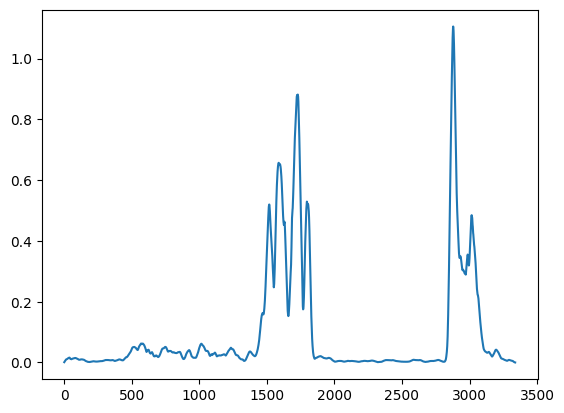

In [ ]:
plt.plot(np.convolve(dissimilarities_normalized[:3300], np.ones(40)/40))

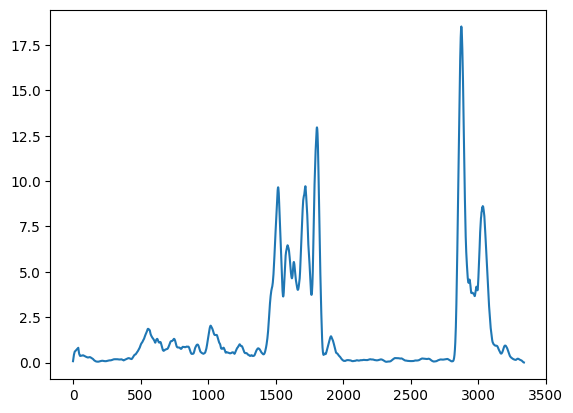

In [ ]:
plt.plot(np.convolve(model.dissimilarities[:3300], np.ones(40)/40))

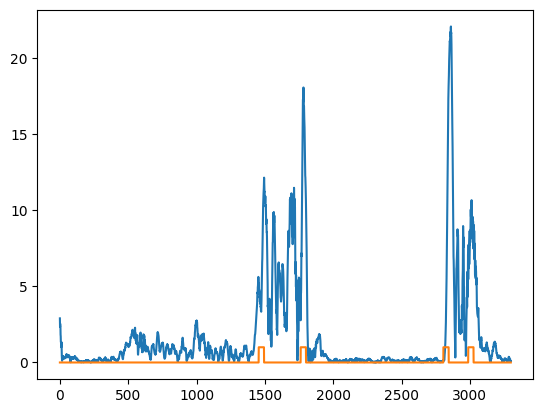

In [ ]:
plt.plot(np.arange(d), model.dissimilarities[:d], np.arange(len(labels)), model.labels_[:d])